<a href="https://colab.research.google.com/github/VetaAgafonova/HPC_labs/blob/Bilateral/Lab3_Bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
!pip install pycuda

In [91]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule
from google.colab import drive

In [92]:
def bilateral_CPU(image, sigma_d, sigma_r, window_size):
    cpu_img = np.zeros(image.shape)
    width, height = image.shape
    half_window = window_size // 2
    for i in range(half_window, width - half_window):
        for j in range(half_window, height - half_window):
          s = c = 0
          for k in range(i - half_window, i + half_window + 1):
              for l in range(j - half_window, j + half_window + 1):
                  if k >= 0 and k < width and l >= 0 and l < height:
                      g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
                      r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)
                      c += g * r
                      s += g * r * image[k, l]
          cpu_img[i, j] = s / c
    return cpu_img

In [93]:
def bilateral_filter(image, sigma_d, sigma_r, window_size):
    M, N = image.shape
    gpu_img = np.zeros((M, N), dtype=np.uint32)
    block = (32, 1, 1)
    grid = (int(np.ceil(M/block[0])), int(np.ceil(N/block[1])))

    bilateral_GPU = SourceModule("""
    texture<unsigned int, 2, cudaReadModeElementType> t;

    __global__ void kernel_gpu(int *  res, const int M, const int N, const int window_size, const float sigma_d, const float sigma_r)
    {
        int i = threadIdx.x + blockDim.x * blockIdx.x;
        int j = threadIdx.y + blockDim.y * blockIdx.y;

        if (i >= M || j >= N)
          return;

        float firstImg, secondImg, g, r, s = 0, c = 0;

        int half_window = window_size / 2;

        for (int l = i - half_window; l <= i + half_window; l++){
            for (int k = j - half_window; k <= j + half_window; k++){
                if (l >= 0 && l < M && k >= 0 && k < N) {
                    firstImg = tex2D(t, k, l) / 255;
                    secondImg = tex2D(t, i, j) / 255;
                    g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                    r = exp(-pow((firstImg - secondImg) * 255, 2) / pow(sigma_r, 2));
                    c += g * r;
                    s += g * r * tex2D(t, k, l);
                }
            }
        }

        res[i * N + j] = s / c;
    }
    """)

    kernel_gpu = bilateral_GPU.get_function("kernel_gpu")
    t = bilateral_GPU.get_texref("t")
    t.set_filter_mode(driver.filter_mode.LINEAR)
    t.set_address_mode(0, driver.address_mode.MIRROR)
    t.set_address_mode(1, driver.address_mode.MIRROR)
    driver.matrix_to_texref(image.astype(np.uint32), t, order="C")
    kernel_gpu(driver.Out(gpu_img), np.int32(M), np.int32(N), np.int32(window_size), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[t])

    return gpu_img

Cat


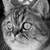

<ipython-input-92-689d7e21db7e>:12: RuntimeWarning: overflow encountered in ubyte_scalars
  r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)


Cat CPU


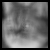

Time CPU:  1.9675335884094238
Cat GPU


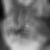

Time GPU:  0.0038857460021972656


In [94]:
img = cv2.imread('/content/drive/MyDrive/img/cat1.bmp', cv2.IMREAD_GRAYSCALE)

sigma_d = 400
sigma_r = 400
window_size = 4

print("Cat")
cv2_imshow(img)

cpu_start = time.time()
cpu_img = bilateral_CPU(img, sigma_d, sigma_r, window_size)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/img/cat1_cpu.bmp', cpu_img)
print("Cat CPU")
cv2_imshow(cpu_img)
print('Time CPU: ', cpu_time)

gpu_start = time.time()
gpu_img = bilateral_filter(img, sigma_d, sigma_r, window_size)
gpu_time = time.time() - gpu_start
print("Cat GPU")
cv2.imwrite('/content/drive/MyDrive/img/cat1_gpu.bmp', gpu_img.astype(np.uint8))
cv2_imshow(gpu_img)
print('Time GPU: ', gpu_time)